# Downloading the raw data

In [5]:
from urllib.request import urlretrieve
import os
import glob
import pandas as pd

output_relative_dir = '../data/'

# check if it exists as it makedir will raise an error if it does exist
if not os.path.exists(output_relative_dir):
    os.makedirs(output_relative_dir)
    
# now, for each type of data set we will need, we will create the paths
for target_dir in ('curated', 'landing', 'raw'): 
    if not os.path.exists(output_relative_dir + target_dir):
        os.makedirs(output_relative_dir + target_dir)

In [10]:
YEAR = '2022'
# adjust the range function to the numerical months i.e 1 = jan, 2 = feb, etc...
MONTHS = [1, 4, 7, 10]

# this is the URL template as of 07/2022
URL_TEMPLATE = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_"#year-month.parquet

# data output directory is `data/raw/`
tlc_output_dir = output_relative_dir + 'raw'

In [42]:
for month in MONTHS:
    # 0-fill i.e 1 -> 01, 2 -> 02, etc
    month = str(month).zfill(2) 
    print(f"Begin month {month}")
    
    # generate url
    url = f'{URL_TEMPLATE}{YEAR}-{month}.parquet'
    # generate output location and filename
    output_dir = f"{tlc_output_dir}/{YEAR}-{month}.parquet"
    # download
    urlretrieve(url, output_dir) 
    
    print(f"Completed month {month}")

Begin month 01
Completed month 01
Begin month 04
Completed month 04
Begin month 07
Completed month 07
Begin month 10
Completed month 10


# Preprocessing

In [2]:
# concat the files
path = r'../data/raw'
all_files = glob.glob(path + "/*.parquet")

li = []

for filename in all_files:
    df = pd.read_parquet(filename)
    li.append(df)

yellow_2022 = pd.concat(li, axis=0, ignore_index=True)
yellow_2022.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12913656 entries, 0 to 12913655
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee         

In [3]:
# check for missing values in the combined data
missing_val = yellow_2022.isnull().sum()

# print the count of missing values for each column
print(missing_val)

if yellow_2022.isnull().any().any():
    print("Missing values exist.")
else:
    print("No missing values.")

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          428592
trip_distance                 0
RatecodeID               428592
store_and_fwd_flag       428592
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     428592
airport_fee              428592
dtype: int64
Missing values exist.


In [4]:
cleaned_yellow_2022 = yellow_2022.dropna()

# remove all data with negative or 0 distance, passenger count
cleaned_yellow_2022 = cleaned_yellow_2022[cleaned_yellow_2022["passenger_count"] > 0]
cleaned_yellow_2022 = cleaned_yellow_2022[cleaned_yellow_2022["trip_distance"] > 0]
# remove all data with fare amount lower than the minimum 2.5
cleaned_yellow_2022 = cleaned_yellow_2022[(cleaned_yellow_2022.fare_amount >= 2.5) & (cleaned_yellow_2022.tolls_amount >= 2.5)]

In [5]:
# convert the 'tpep_pickup_datetime' column to datetime format and extract just the date and time (by hour)
cleaned_yellow_2022["date"] = pd.to_datetime(cleaned_yellow_2022["tpep_pickup_datetime"]).dt.date
cleaned_yellow_2022['hour'] = cleaned_yellow_2022['tpep_pickup_datetime'].dt.hour
cleaned_yellow_2022['day'] = cleaned_yellow_2022['tpep_pickup_datetime'].dt.day_name()

# drop rows where the pick up and drop off date is out of range
cleaned_yellow_2022 = cleaned_yellow_2022[cleaned_yellow_2022['tpep_pickup_datetime'].dt.month.isin([1, 4, 7, 10])]
cleaned_yellow_2022 = cleaned_yellow_2022[cleaned_yellow_2022['tpep_dropoff_datetime'].dt.month.isin([1, 4, 7, 10])]

# calculate the trip duration in minutes
cleaned_yellow_2022['trip_duration'] = (cleaned_yellow_2022['tpep_dropoff_datetime'] - 
                                        cleaned_yellow_2022['tpep_pickup_datetime']).dt.total_seconds() / 60

# replace 0 with small number
small_number = 1e-5
cleaned_yellow_2022['trip_distance'].replace(0, small_number, inplace=True)
cleaned_yellow_2022['trip_duration'].replace(0, small_number, inplace=True)

# print the shape of the original and cleaned data
print("Original DataFrame shape:", yellow_2022.shape)
print("Cleaned DataFrame shape:", cleaned_yellow_2022.shape)

Original DataFrame shape: (12913656, 19)
Cleaned DataFrame shape: (881916, 23)


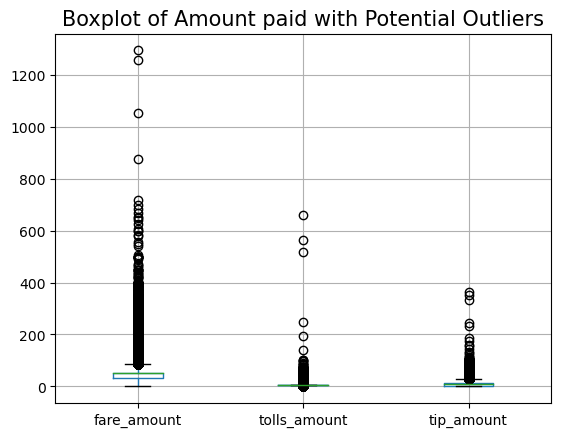

In [6]:
import matplotlib.pyplot as plt

# create a new directory named 'plots' if it doesn't exist
if not os.path.exists('../plots'):
    os.makedirs('../plots')

# specify the columns to check for outliers
col = ["fare_amount", "tolls_amount", "tip_amount"]

# plot a boxplot to visualize the distribution and identify potential outliers
cleaned_yellow_2022[col].boxplot()
plt.title("Boxplot of Amount paid with Potential Outliers", fontsize=15)
plt.savefig('../plots/boxplot of amount paid.png')
plt.show()


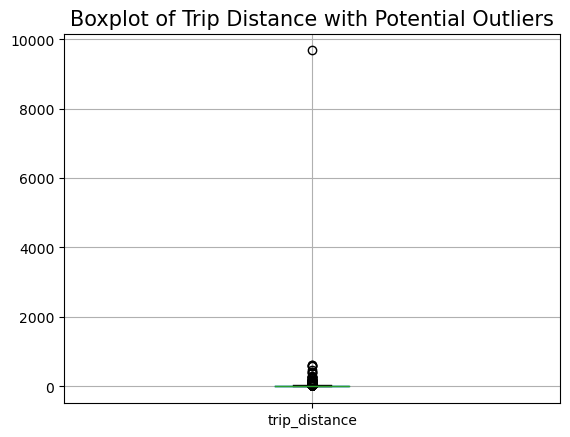

In [7]:
# plot a boxplot to visualize the distribution and identify potential outliers
cleaned_yellow_2022.boxplot(column = "trip_distance")
plt.title("Boxplot of Trip Distance with Potential Outliers", fontsize=15)
plt.savefig('../plots/boxplot of trip distance.png')

plt.show()

In [8]:
# removing outliers in amount paid using the interquantile range
Q1_col = cleaned_yellow_2022[col].quantile(0.25)
Q3_col = cleaned_yellow_2022[col].quantile(0.75)
IQR_col = Q3_col - Q1_col

cleaned_amount = ((cleaned_yellow_2022[col] < (Q1_col - 3 * IQR_col)) |
                 (cleaned_yellow_2022[col] > (Q3_col + 3 * IQR_col)))

cleaned = cleaned_yellow_2022[~cleaned_amount.any(axis=1)]

# removing outliers in trip distance using the interquantile range
Q1_dis = cleaned_yellow_2022['trip_distance'].quantile(0.25)
Q3_dis = cleaned_yellow_2022['trip_distance'].quantile(0.75)
IQR_dis = Q3_dis - Q1_dis

# use three times the IQR for a lenient approach of detecting outliers
cleaned_distance = ((cleaned_yellow_2022['trip_distance'] < (Q1_dis - 3 * IQR_dis)) |
                 (cleaned_yellow_2022['trip_distance'] > (Q3_dis + 3 * IQR_dis)))

cleaned_all = cleaned[~cleaned_distance]

cleaned_all


/var/folders/cz/_2rhpg0x7_x620mkkm6cwfgm0000gn/T/ipykernel_51350/1497328079.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_all = cleaned[~cleaned_distance]


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,date,hour,day,trip_duration
6,1,2022-04-01 00:14:20,2022-04-01 00:28:57,1.0,7.20,1.0,N,138,42,3,...,0.00,6.55,0.3,29.60,0.0,1.25,2022-04-01,0,Friday,14.616667
27,2,2022-04-01 00:40:02,2022-04-01 01:15:49,1.0,7.58,1.0,N,100,145,2,...,0.00,6.55,0.3,38.85,2.5,0.00,2022-04-01,0,Friday,35.783333
58,1,2022-04-01 00:28:37,2022-04-01 00:47:48,1.0,8.10,1.0,N,75,138,1,...,3.00,6.55,0.3,34.85,0.0,0.00,2022-04-01,0,Friday,19.183333
63,2,2022-04-01 00:58:42,2022-04-01 01:41:42,3.0,18.30,2.0,N,132,48,1,...,12.37,6.55,0.3,75.47,2.5,1.25,2022-04-01,0,Friday,43.000000
74,1,2022-04-01 00:10:13,2022-04-01 00:37:01,1.0,11.20,1.0,N,138,48,1,...,8.00,6.55,0.3,53.10,2.5,1.25,2022-04-01,0,Friday,26.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12842035,2,2022-01-31 23:04:46,2022-01-31 23:32:18,1.0,13.72,1.0,N,264,148,1,...,9.87,6.55,0.3,59.22,2.5,0.00,2022-01-31,23,Monday,27.533333
12842086,1,2022-01-31 23:03:29,2022-01-31 23:25:57,1.0,9.30,1.0,N,138,238,1,...,2.00,6.55,0.3,42.10,2.5,1.25,2022-01-31,23,Monday,22.466667
12842095,2,2022-01-31 23:18:04,2022-01-31 23:35:21,2.0,9.93,1.0,N,138,229,1,...,7.87,6.55,0.3,48.47,2.5,1.25,2022-01-31,23,Monday,17.283333
12842097,2,2022-01-31 23:04:23,2022-01-31 23:38:29,1.0,20.84,2.0,N,132,140,1,...,12.62,6.55,0.3,75.72,2.5,1.25,2022-01-31,23,Monday,34.100000


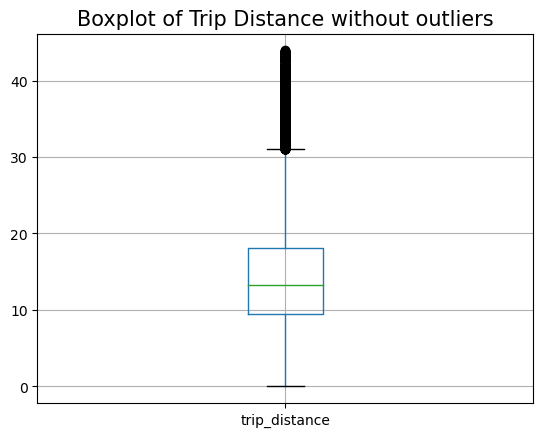

In [9]:
# plot a boxplot to visualize the distribution after removing the outliers
cleaned_all.boxplot(column = "trip_distance")
plt.title("Boxplot of Trip Distance without outliers", fontsize=15)
plt.savefig('../plots/boxplot of trip distance without outliers.png')

plt.show()

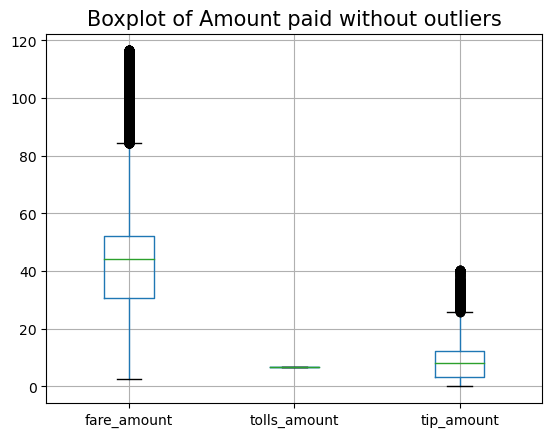

In [10]:
cleaned_all[col].boxplot()
plt.title("Boxplot of Amount paid without outliers", fontsize=15)
plt.savefig('../plots/boxplot of amount paid without outliers.png')
plt.show()


In [11]:
# row with the maximum total amount
max_total_index = cleaned_all['total_amount'].idxmax()
row_with_max_total = cleaned_all.loc[max_total_index]
print(row_with_max_total)

# row with the maximum trip distance
max_duration_index = cleaned_all['trip_duration'].idxmax()
row_with_max_duration = cleaned_all.loc[max_duration_index]
print(row_with_max_duration)

VendorID                                   2
tpep_pickup_datetime     2022-10-21 23:13:13
tpep_dropoff_datetime    2022-10-22 01:13:49
passenger_count                          2.0
trip_distance                          32.74
RatecodeID                               1.0
store_and_fwd_flag                         N
PULocationID                              48
DOLocationID                             202
payment_type                               1
fare_amount                            114.5
extra                                    0.5
mta_tax                                  0.5
tip_amount                              35.0
tolls_amount                            6.55
improvement_surcharge                    0.3
total_amount                          159.85
congestion_surcharge                     2.5
airport_fee                              0.0
date                              2022-10-21
hour                                      23
day                                   Friday
trip_durat

In [12]:
# drop rows where trip_duration is greater than 150 less than 1
cleaned_all = cleaned_all[(cleaned_all['trip_duration'] >= 1) 
                                          & (cleaned_all['trip_duration'] <= 150)]

In [13]:
# save clean data in parquet format
preprocessed_path = "../data/landing/cleaned_data.parquet"
cleaned_all.to_parquet(preprocessed_path, index=False)

In [14]:
# read in the weather data
weather = pd.read_csv("../data/nyc_weather_2022.csv")
# save into raw folder
weather.to_csv('../data/raw/nyc_weather_2022.csv')

weather.head()


,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WT01,WT02,WT03,WT04,WT06,WT08
0,USW00094728,2022-01-01,1.4,20.1,0.0,0.0,NaN,13.3,10.0,1.0,NaN,NaN,NaN,NaN,NaN
1,USW00094728,2022-01-02,2.6,1.0,0.0,0.0,NaN,15.0,2.8,1.0,NaN,NaN,NaN,NaN,NaN
2,USW00094728,2022-01-03,4.4,0.0,0.0,0.0,NaN,2.8,-5.5,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00094728,2022-01-04,2.7,0.0,0.0,0.0,NaN,1.1,-7.1,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00094728,2022-01-05,2.5,5.8,0.0,0.0,NaN,8.3,-0.5,1.0,NaN,NaN,NaN,1.0,NaN


In [15]:
# convert the date to datetime datatype
weather['DATE'] = pd.to_datetime(weather['DATE'])

# keep the relevant date for the desired months
weather = weather[weather["DATE"].dt.month.isin(MONTHS)]

# average temperature missing, replaced by using (TMAX + TMIN)/2
weather['TAVG'] = (weather['TMAX'] + weather['TMIN']) / 2

# replace NaN to 0
weather[['WT01', 'WT02', 'WT03', 'WT06', 'WT08']] = weather[['WT01', 'WT02', 'WT03', 'WT06', 'WT08']].fillna(0)

# only select the relevant columns to analyse
new_weather = weather.drop(columns=["WT04"])

new_weather

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WT01,WT02,WT03,WT06,WT08
0,USW00094728,2022-01-01,1.4,20.1,0.0,0.0,11.65,13.3,10.0,1.0,0.0,0.0,0.0,0.0
1,USW00094728,2022-01-02,2.6,1.0,0.0,0.0,8.90,15.0,2.8,1.0,0.0,0.0,0.0,0.0
2,USW00094728,2022-01-03,4.4,0.0,0.0,0.0,-1.35,2.8,-5.5,0.0,0.0,0.0,0.0,0.0
3,USW00094728,2022-01-04,2.7,0.0,0.0,0.0,-3.00,1.1,-7.1,0.0,0.0,0.0,0.0,0.0
4,USW00094728,2022-01-05,2.5,5.8,0.0,0.0,3.90,8.3,-0.5,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,USW00094728,2022-10-27,3.0,0.0,0.0,0.0,14.70,18.3,11.1,0.0,0.0,0.0,0.0,0.0
300,USW00094728,2022-10-28,2.5,0.0,0.0,0.0,10.25,13.3,7.2,0.0,0.0,0.0,0.0,0.0
301,USW00094728,2022-10-29,1.5,0.0,0.0,0.0,10.25,14.4,6.1,0.0,0.0,0.0,0.0,0.0
302,USW00094728,2022-10-30,0.4,0.0,0.0,0.0,11.65,17.2,6.1,0.0,0.0,0.0,0.0,0.0


In [16]:
weather_columns = ['WT01', 'WT02', 'WT03', 'WT06', 'WT08']

# calculate the "bad weather" column
new_weather['bad_weather'] = new_weather[weather_columns].apply(lambda row: 1 if row.any() else 0, axis=1)

# drop the weather columns
new_weather.drop(columns=weather_columns, inplace=True)

new_weather

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,bad_weather
0,USW00094728,2022-01-01,1.4,20.1,0.0,0.0,11.65,13.3,10.0,1
1,USW00094728,2022-01-02,2.6,1.0,0.0,0.0,8.90,15.0,2.8,1
2,USW00094728,2022-01-03,4.4,0.0,0.0,0.0,-1.35,2.8,-5.5,0
3,USW00094728,2022-01-04,2.7,0.0,0.0,0.0,-3.00,1.1,-7.1,0
4,USW00094728,2022-01-05,2.5,5.8,0.0,0.0,3.90,8.3,-0.5,1
...,...,...,...,...,...,...,...,...,...,...
299,USW00094728,2022-10-27,3.0,0.0,0.0,0.0,14.70,18.3,11.1,0
300,USW00094728,2022-10-28,2.5,0.0,0.0,0.0,10.25,13.3,7.2,0
301,USW00094728,2022-10-29,1.5,0.0,0.0,0.0,10.25,14.4,6.1,0
302,USW00094728,2022-10-30,0.4,0.0,0.0,0.0,11.65,17.2,6.1,0


In [17]:
# save the data in the curated file
new_weather.to_csv('../data/landing/nyc_weather_2022.csv')